In [1]:
import numpy as np

#Define network

순전파와 역전파가 어떻게 구현되는지 확인해보세요!

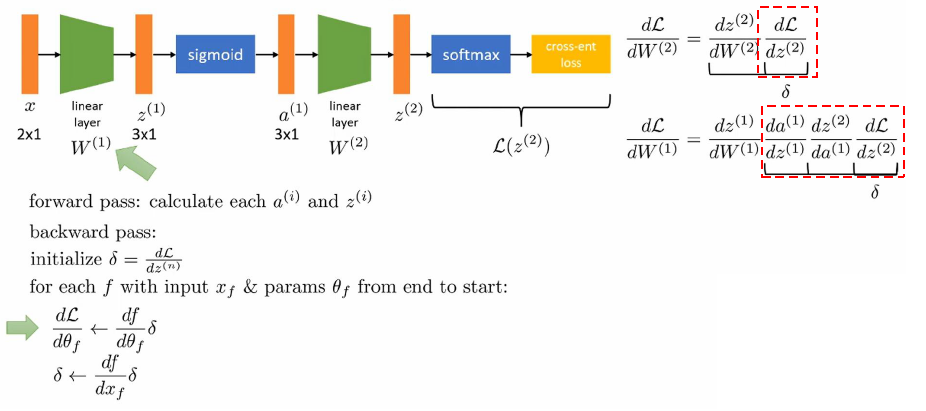

In [2]:
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()


    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # forward
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)


    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

#Layers

각 레이어에는 init, forward, backward 함수가 정의되어 있습니다.

In [3]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b

        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)

        # 계산 그래프를 직접 그려보세요(권장)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)
        return dx

In [4]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [5]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

#Functions

복습차원에서 빈칸을 채워봅시다!

In [6]:
def softmax(x):
    '''
    x: n x num_class
    '''
    # 계산 안정성 추가
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [7]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

#Optimizers

파라미터와 기울기를 인수로 받아서 파라미터를 갱신합니다.

SGD는 파라미터를 업데이트할 때, 각 반복마다 계산된 **기울기(gradient)**를 이용하여 파라미터를 업데이트합니다.

$$
\theta_{t+1} = \theta_t - \eta \nabla_\theta J(\theta_t)
$$

- $\theta_t$ : 파라미터  
- $\eta$ : 학습률(learning rate)  
- $\nabla_\theta J(\theta_t)$ : 파라미터에 대한 손실 함수의 기울기(gradient)  

In [8]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

Momentum은 이전 기울기를 반영하여 학습을 가속화하는 방법입니다.

$$
v_{t+1} = \alpha v_t - \eta \nabla_\theta J(\theta_t)
$$
$$
\theta_{t+1} = \theta_t + v_{t+1}
$$

- $ v_t $ : 이전 기울기 업데이트
- $ \alpha $ : 모멘텀 하이퍼파라미터 (0 < $ \alpha $ < 1)
- $ \nabla_\theta J(\theta_t) $ : 현재 기울기
- $ \eta $ : 학습률

In [9]:
class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

Adagrad는 학습이 진행될수록 각 파라미터의 학습률이 감소합니다.

$$
G_t = G_{t-1} + \nabla_\theta J(\theta_t)^2
$$
$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \nabla_\theta J(\theta_t)
$$

- $ G_t $ : 기울기의 제곱 합(누적)
- $ \epsilon $ : 작은 값 (수치 안정성 보장)
- $ \eta $ : 학습률
- $ \nabla_\theta J(\theta_t) $ : 현재 기울기

In [10]:
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#Training

**MNIST 손글씨 dataset**

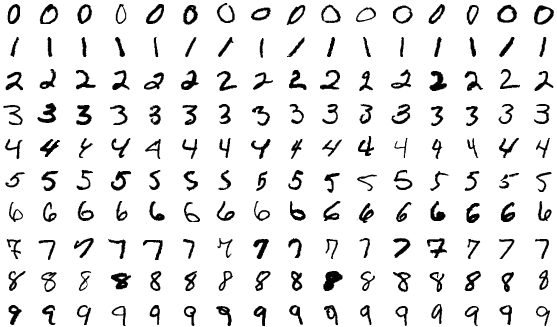

In [11]:
from torchvision import datasets

# MNIST load
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True)


# flatten(28*28), normalization(0~1)
x_train = mnist_train.data.view(-1, 28 * 28).numpy().astype('float32') / 255.0
t_train = mnist_train.targets.numpy()
x_test  = mnist_test.data.view(-1, 28 * 28).numpy().astype('float32') / 255.0
t_test  = mnist_test.targets.numpy()

# one-hot encoding
n = len(np.unique(t_train))  # 보통 10
t_train = np.eye(n)[t_train]
t_test  = np.eye(n)[t_test]

print(f'x_train.shape: {x_train.shape}')  # (60000, 784)
print(f't_train.shape: {t_train.shape}')  # (60000, 10)
print(f'x_test.shape:  {x_test.shape}')   # (10000, 784)
print(f't_test.shape:  {t_test.shape}')   # (10000, 10)

x_train.shape: (60000, 784)
t_train.shape: (60000, 10)
x_test.shape:  (10000, 784)
t_test.shape:  (10000, 10)


https://docs.pytorch.org/vision/stable/datasets.html

MNIST말고도 다양한 데이터셋이 있습니다 :)



1. batch_size, learning_rate 등 하이퍼파라미터를 변경해보세요!
2. 세 종류의 optimizer를 써보고 train loss 그래프를 비교해보세요!

In [14]:
from collections import OrderedDict

class MultiLayerNet:
    def __init__(self, input_size, hidden_size_list, output_size, weight_init_std=0.01):

        self.params = {}
        self.layers = OrderedDict()
        self.hidden_size_list = hidden_size_list
        self.output_size = output_size

        layer_size_list = [input_size] + hidden_size_list + [output_size]

        for i in range(len(layer_size_list) - 1):
            self.params['W' + str(i+1)] = weight_init_std * np.random.randn(
                layer_size_list[i], layer_size_list[i+1]
            )
            self.params['b' + str(i+1)] = np.zeros(layer_size_list[i+1])

        for i in range(len(hidden_size_list)):
            self.layers['Affine' + str(i+1)] = Affine(
                self.params['W' + str(i+1)],
                self.params['b' + str(i+1)]
            )
            self.layers['Relu' + str(i+1)] = Relu()

        last_idx = len(hidden_size_list) + 1
        self.layers['Affine' + str(last_idx)] = Affine(
            self.params['W' + str(last_idx)],
            self.params['b' + str(last_idx)]
        )

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
            accuracy = np.sum(y == t) / float(x.shape[0])
            return accuracy

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for i in range(len(self.hidden_size_list) + 1):
            grads['W' + str(i+1)] = self.layers['Affine' + str(i+1)].dW
            grads['b' + str(i+1)] = self.layers['Affine' + str(i+1)].db

        return grads


In [15]:
network = TwoLayerNet(input_size=28*28*1, hidden_size=50, output_size=10)
network = MultiLayerNet(input_size=28*28*1, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)

# 데이터셋 60000개, 배치 당 100개 -> 600번 반복해야 한 데이터셋 다 봄(=1epoch)
iters_num = 6000 # 몇 epoch 일까요? -> 10 epoch
train_size = x_train.shape[0] # 60000
batch_size = 100
learning_rate = 1e-2

optimizers = {'sgd':SGD, 'momentum':Momentum, 'adagrad':AdaGrad}
train_loss_list = {key:[] for key in optimizers.keys()}

iter_per_epoch = max(train_size / batch_size, 1)


for key in optimizers.keys():
    print(f"\n====== Training with {key.upper()} optimizer ======")
    # Re-initialize network for each optimizer to ensure a fair comparison
    current_network = MultiLayerNet(input_size=28*28*1, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)

    if key == 'momentum':
        current_optimizer = optimizers[key](lr=learning_rate, momentum=0.9)
    else:
        current_optimizer = optimizers[key](lr=learning_rate)

    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grad = current_network.gradient(x_batch, t_batch)
        current_optimizer.update(current_network.params, grad)

        loss = current_network.loss(x_batch, t_batch)
        train_loss_list[key].append(loss)

        if i % iter_per_epoch == 0:
            train_acc = current_network.accuracy(x_train, t_train)
            test_acc = current_network.accuracy(x_test, t_test)
            print('Epoch {:.0f}, train: {:.4f}, test: {:.4f}'.format(i//iter_per_epoch, train_acc, test_acc))


====== Training with SGD optimizer ======
Epoch 0, train: 0.0975, test: 0.0974
Epoch 1, train: 0.1124, test: 0.1135
Epoch 2, train: 0.1124, test: 0.1135
Epoch 3, train: 0.1124, test: 0.1135
Epoch 4, train: 0.1124, test: 0.1135
Epoch 5, train: 0.1124, test: 0.1135
Epoch 6, train: 0.1124, test: 0.1135
Epoch 7, train: 0.1124, test: 0.1135
Epoch 8, train: 0.1124, test: 0.1135
Epoch 9, train: 0.1124, test: 0.1135

====== Training with MOMENTUM optimizer ======
Epoch 0, train: 0.1124, test: 0.1135
Epoch 1, train: 0.1124, test: 0.1135
Epoch 2, train: 0.1124, test: 0.1135
Epoch 3, train: 0.1124, test: 0.1135
Epoch 4, train: 0.1124, test: 0.1135
Epoch 5, train: 0.1124, test: 0.1135
Epoch 6, train: 0.1124, test: 0.1135
Epoch 7, train: 0.1124, test: 0.1135
Epoch 8, train: 0.1124, test: 0.1135
Epoch 9, train: 0.1124, test: 0.1135

====== Training with ADAGRAD optimizer ======
Epoch 0, train: 0.0992, test: 0.1009
Epoch 1, train: 0.7160, test: 0.7164
Epoch 2, train: 0.8004, test: 0.7974
Epoch 3, tr

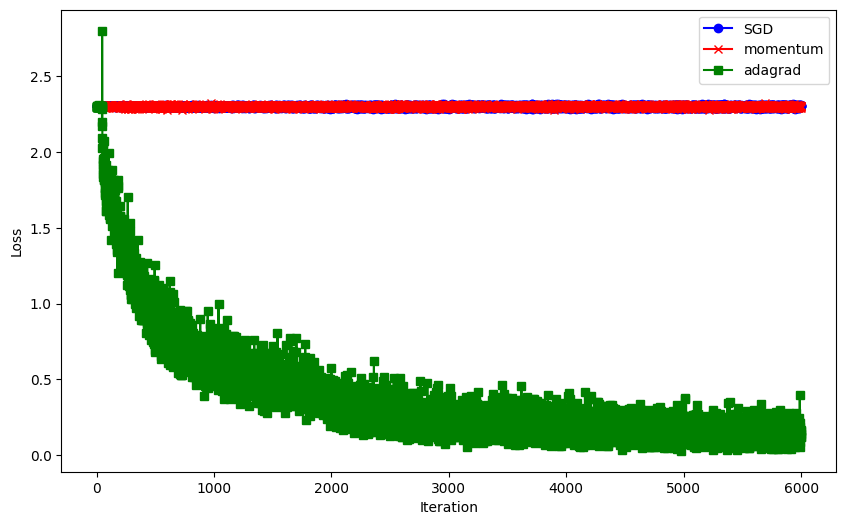

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(train_loss_list['sgd'], label='SGD', marker='o', linestyle='-', color='b')
plt.plot(train_loss_list['momentum'], label='momentum', marker='x', linestyle='-', color='r')
plt.plot(train_loss_list['adagrad'], label='adagrad', marker='s', linestyle='-', color='g')


plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.legend()

plt.show()

### 문제: 각 optimizer의 특징을 비교해주세요!
- SGD: 현재 기울기만을 사용해 파라미터를 갱신하는 방법
- momentum: 이전 기울기의 방향을 누적해 관성처럼 사용하여 SGD의 진동을 줄이고 수렴 속도를 개선한 방법
- adagrad: 파라미터별로 학습률을 자동 조절하여 자주 업데이트되는 값의 학습률은 줄이고 드문 값은 유지하는 방법